# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import keras
import tensorflow as tf

import csv
import cv2
import numpy as np
import pandas as pd
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

C:\Users\Venkatesh K Govindan\anaconda3\envs\PythonGPU\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Change directory

In [2]:
import os
os.getcwd()

'C:\\Users\\Venkatesh K Govindan\\PGP-AIML\\Residency 12-Advanced CNN\\Internal Lab\\ACV Lab Questions and Data Set'

### Load the training data from train.csv file

In [3]:
raccoon_df=pd.read_csv('train_labels.csv')
raccoon_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [4]:
raccoon_df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [5]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [6]:
img_path='C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/images/'

In [7]:
with open('train_labels.csv', 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader, None)
    for col, row in enumerate(reader):   
        for i, j in enumerate(row):
            if ((i!=0) & (i!=3)):
                row[i] = int(j)
        path, image_width, image_height, class_, x0, y0, x1, y1 = row
        paths.append(img_path+path)
        coords[col, 0] = x0 * IMAGE_SIZE / image_width 
        coords[col, 1] = y0 * IMAGE_SIZE / image_height 
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width 
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height

In [8]:
paths[:5]

['C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/images/raccoon-17.jpg',
 'C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/images/raccoon-11.jpg',
 'C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/images/raccoon-63.jpg',
 'C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/images/raccoon-63.jpg',
 'C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/images/raccoon-60.jpg']

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [9]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [10]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) 

for layer in model.layers:
    layer.trainable = False

x = model.layers[-1].output
x = Conv2D(4, kernel_size=4)(x)
x = Reshape((4,))(x)

model = Model(inputs=model.input, outputs=x)

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [12]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [13]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

In [14]:
model.fit(batch_images, gt, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
173/173 [==============================] - 3s 19ms/step - loss: 2862.9242 - IoU: 0.1008
Epoch 2/30
173/173 [==============================] - 1s 5ms/step - loss: 688.0465 - IoU: 0.4452
Epoch 3/30
173/173 [==============================] - 1s 5ms/step - loss: 619.8480 - IoU: 0.5331
Epoch 4/30
173/173 [==============================] - 1s 5ms/step - loss: 542.6824 - IoU: 0.5507
Epoch 5/30
173/173 [==============================] - 1s 5ms/step - loss: 316.0521 - IoU: 0.6075
Epoch 6/30
173/173 [==============================] - 1s 5ms/step - loss: 274.9681 - IoU: 0.5748
Epoch 7/30
173/173 [==============================] - 1s 5ms/step - loss: 234.6707 - IoU: 0.6191
Epoch 8/30
173/173 [==============================] - 1s 5ms/step - loss: 194.4197 - IoU: 0.6591
Epoch 9/30
173/173 [==============================] - 1s 5ms/step - loss: 160.8194 - IoU: 0.7041
Epoch 10/30
173/173 [==============================] - 1s 5ms/step - loss: 144.5095 - IoU: 0.7127
Epoch 11/30
173/173 [======

### Pick a test image from the given data

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

In [16]:
test_img = 'C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/images/raccoon-25.jpg'
unscaled=cv2.imread(test_img)
unscaled.shape

(641, 634, 3)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [17]:
image_height, image_width, _ = unscaled.shape

In [18]:
image=cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled=preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [19]:
region=model.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

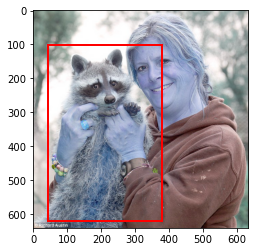

In [20]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### *** Prediction using unseen image out of training dataset

In [21]:
test_img = 'C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/Rocket Raccoon.jpg'
unscaled=cv2.imread(test_img)
image_height, image_width, _ = unscaled.shape
image=cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled=preprocess_input(np.array(image, dtype=np.float32))
region=model.predict(x=np.array([feat_scaled]))[0]

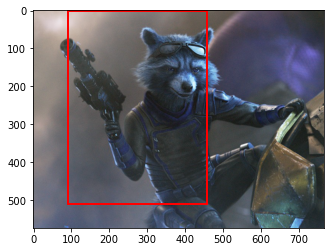

In [22]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [23]:
test_img = 'C:/Users/Venkatesh K Govindan/PGP-AIML/Residency 12-Advanced CNN/Internal Lab/ACV Lab Questions and Data Set/images_racoon/Rocket Raccoon1.jpg'
unscaled=cv2.imread(test_img)
image_height, image_width, _ = unscaled.shape
image=cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled=preprocess_input(np.array(image, dtype=np.float32))
region=model.predict(x=np.array([feat_scaled]))[0]

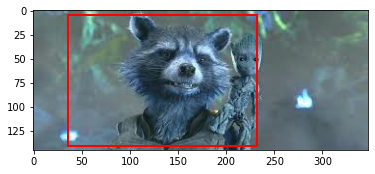

In [24]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()